In [2]:
import matplotlib
import numpy as np
# matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt 
import scipy as sp
from scipy.sparse import linalg as ln
from scipy import sparse as sparse
import matplotlib.animation as animation
 


# Hoe werkt de code

Het begin van de code lijkt erg op het oplossen van de eindig/oneindig diepe put. Echter wordt nu geen eigenwaarde probleem opgelost, maar een initial wavefunction gegeven.

De initial wavefunction voor een Gauss-pakket:

$$\psi(x,0) = \left(2 \pi \sigma^2 \right)^{-1/4}\ e^{-(\frac{x - x_{0}}{2 \sigma})^2}\ e^{ikx}$$

Dan wordt met de finite infinite method de hamiltonian bepaald. Hieruit volgt dezelfde matrix als bij de putten.

$$
\hat{H} = \begin{bmatrix}
\frac{1}{\Delta x'^2}+V'_1 & -\frac{1}{2 \Delta x'^2} &   0 & 0...\\
-\frac{1}{2 \Delta x'^2} & \frac{1}{\Delta x'^2}+V'_2 & -\frac{1}{2 \Delta y^2} & 0... \\
...& ... & ... & -\frac{1}{2 \Delta x^2}\\
...0 & 0 & -\frac{1}{2 \Delta x'^2} & \frac{1}{\Delta x'^2}+V'_{N-1}\\
\end{bmatrix}$$


Dan gaan we naar de time dependent Schrödinger vergelijking. 

$$i \frac{d \psi(x,t)}{dt} = H\psi(x,t)$$


Nu wordt er een voorwaartse en een achterwaartse (?) euler methode toepast

voorwaatste eulermethode: zelfde principe als FDM, maar dan voor 1e orde diff. vergelijking.

$$\frac{d\psi(x,t)}{dt} \approx \frac{\psi(x, t + dt) - \psi(x,t)}{dt}$$

Achterwaartse:

$$\frac{d\psi(x,t)}{dt} \approx \frac{\psi(x,t) - \psi(x, t-dt)}{dt}$$

Bij achterwaartste alles verschuiven met $dt$

Achterwaartse verschoven:

$$\frac{d\psi(x,t+dt)}{dt} \approx \frac{\psi(x,t+dt) - \psi(x, t)}{dt}$$

Beide invullen in de Schrödinger vergelijking geeft een voorwaartse en achterwaartse vergelijking

$$\begin{align*}
\frac{\psi(x,t+dt) - \psi(x,t)}{dt} &= -i H \psi(x,t)\\
\frac{\psi(x,t+dt) - \psi(x,t)}{dt} &= -i H \psi(x,t + dt)
\end{align*}$$

Formules bij elkaar optellen geeft de **Crank-Nicolson formule**

$$\frac{\psi(x,t+dt) - \psi(x,t)}{dt} = \frac{1}{2i} H \psi(x,t) + \frac{1}{2i} H \psi(x,t + dt)$$

Formule oplossen voor $\psi(x,t+dt)$:

$$\psi(x,t+dt) = \left(1-\frac{dt}{2i}H \right)^{-1}\left(1+\frac{dt}{2i}H \right) \psi(x,t)$$

Dit is weer een lineaire algebra probleem dat snel opgelost kan worden.



## Extra note

De matrices hebben veel 0-waardes
- Gebruik van sparse matrices zeer aangeraden (aangezien de matrices symmetries zijn kunnen de diagonalen als rijen in de sparse matrix opgeslagen worden en hoeven alle 0-waardes niet meegenomen te worden)

- implicite en explicite atrices opslaan in csc-format (compressed sparse column)
    - De rij-index van alle waardes wordt opgeslagen en de kolomn wordt een pointer (geheugenadres) toegewezen.
- Crank-Nicolson matrix in csr-format (compressed sparse row) opslaan
    - De kolomn-index van alle waardes wordt opgeslagen en de rij wordt een pointer toegewezen.
    - maakt matrix-vector vermenigvuldigen efficiënter.


## Extra extra note

Het is makkelijker om deze hele uitleg te coderen in een class zodat de golffunctie als class wordt opgeslagen. Daarna kan over de verschillende functies in de class geïttereerd worden de golffunctie over de x-as te verschuiven door de tijdseenheid aan te passen





In [3]:
class Wave_packet:
    def __init__(self, N, dt, sigma0=5.0, k0=1.0, x0=-150.0, x_begin=-200.0,
                x_end=200.0, barrier_height=1.0, barrier_width=3.0):
        
        self.N = N
        self.dt = dt
        self.sigma0 = sigma0
        self.k0 = k0
        self.x0 = x0
        self.x_begin = x_begin
        self.x_end = x_end
        self.barrier_height = barrier_height
        self.barrier_width = barrier_width

        self.x, self.dx = np.linspace(self.x_begin, self.x_end, self.N, retstep=True)

        norm = (2.0 * np.pi * self.sigma0**2)**(-0.25)

        self.psi = norm * np.exp(-(self.x - self.x0)**2 / (4.0 * self.sigma0**2))*np.exp(1.0j * self.k0 * self.x)
        self.potential = self.barrier_height * ((self.x >= 0) * (self.x < self.barrier_width )).astype(float)
        main = 1/(self.dx**2) * np.ones(self.N) + self.potential
        off = -1/(2*self.dx**2) * np.ones(len(main)-1)
        H = sparse.diags([main, off, off], [0, 1, -1])

        implicit = (sparse.eye(self.N) - self.dt / 2.0j * H).tocsc()
        explicit = (sparse.eye(self.N) + self.dt / 2.0j * H).tocsc()

        self.evolution_matrix = ln.inv(implicit).dot(explicit).tocsr()

    def evolve(self):
        self.psi = self.evolution_matrix.dot(self.psi)
        self.prob = abs(self.psi)**2

        norm = np.sum(self.prob)

        self.prob /= norm
        self.psi /= norm**(0.5)

        return self.prob

In [17]:
class Animator:
    
    def __init__(self, wavepacket):
        self.time = 0.0
        self.wavepacket = wavepacket
        self.fig, self.ax = plt.subplots()
        plt.plot(self.wavepacket.x, self.wavepacket.potential*0.1, color='r')

        self.line, = self.ax.plot(self.wavepacket.x, self.wavepacket.evolve())

    def time_step(self):

        self.prob_b = []
        self.prob_a = []

        while True:
            self.time += self.wavepacket.dt
            if wavepacket.x <= 0 :
                prob1 = np.sum(np.abs(wavepacket.psi)**2)
                prob_b.append(prob1)

            yield self.wavepacket.evolve()

    def update(self, data):
        self.line.set_ydata(data)
        return self.line,

    def animate(self):
        self.ani = animation.FuncAnimation(
            self.fig, self.update, frames = self.time_step, interval=5, blit=False, save_count=650
        )
        writer = animation.PillowWriter(fps=30)
        self.ani.save('tunnel.gif', writer=writer)

    

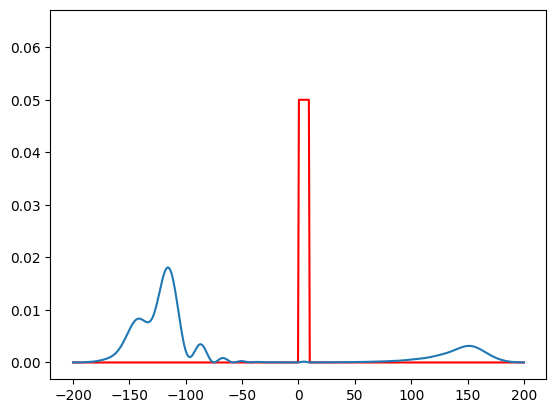

In [16]:
packet = Wave_packet(N=500, dt=30, barrier_width=10, barrier_height = 0.5)
animator = Animator(packet)
animator.animate()


<img src="tunnel.gif" width="750" align="center">